<a href="https://colab.research.google.com/github/jcuesta123/TFM-RL/blob/main/helicopter_landing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#IMPORTS

import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
#STATE, FEATURES, ACTIONS

state = np.array([0., 0., 0., 0., 0., 0.]) # x,y,v_x,v_y,T,theta
num_features = state.size
num_actions = 5 # no action, more traction, less traction, more angle, less angle

In [54]:
#NEURONAL NETWORKS

class DQN(nn.Module):
    """Dense neural network class."""
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, num_actions)

    def forward(self, states):
        """Forward pass."""
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_nn = DQN(num_features, num_actions).to(device)
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [7]:
#BUFFER MEMORY

class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size, device="cpu"):
    """Initializes the buffer."""
    self.buffer = deque(maxlen=size)
    self.device = device

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = torch.as_tensor(np.array(states), device=self.device)
    actions = torch.as_tensor(np.array(actions), device=self.device)
    rewards = torch.as_tensor(np.array(rewards, dtype=np.float32), device=self.device
    )
    next_states = torch.as_tensor(np.array(next_states), device=self.device)
    dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
    return states, actions, rewards, next_states, dones

In [8]:
#TRAIN FUNCTION

def train_step(states, actions, rewards, next_states, dones):

  max_next_qs = target_nn(next_states).max(-1).values
  target = rewards + (1.0 - dones) * discount * max_next_qs
  qs = main_nn(states)
  action_masks = F.one_hot(actions, num_actions)
  masked_qs = (action_masks * qs).sum(dim=-1)
  loss = loss_fn(masked_qs, target.detach())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [10]:
#ACTION FUNCTION

def select_epsilon_greedy_action(state, epsilon):

  result = np.random.uniform()

  if result < epsilon:
    return random.randint(0, num_actions-1)   #random action
  else:
    qs = main_nn(state).cpu().data.numpy()    #NN action
    return np.argmax(qs)

In [11]:
#PARAMETERS
g = 10
m_h = 1
deltaT = 0.1

max_action_space = np.array([2*m_h*g, math.pi/4])
min_action_space = np.array([0, -math.pi/4])

In [57]:
#ENVIRONMENT FUNCTION

def environment(state, action):

  new_state = state
  done = False

  #processing action
  if action == 1:
    new_state[4] = state[4] + max_action_space[0]/100
  elif action == 2:
    new_state[4] = state[4] - max_action_space[0]/100
  elif action == 3:
    new_state[5] = state[5] + max_action_space[1]/1000
  elif action == 4:
    new_state[5] = state[5] - max_action_space[1]/1000
  else: # if action == 0 -> no action
    pass

  #to not surpass limits
  if new_state[4] > max_action_space[0]:
    new_state[4] = max_action_space[0]
  elif new_state[4] < min_action_space[0]:
    new_state[4] = min_action_space[0]
  elif new_state[5] > max_action_space[1]:
    new_state[5] = max_action_space[1]
  elif new_state[5] < min_action_space[1]:
    new_state[5] = min_action_space[1]
  else:
    pass

  #Mechanics
  #Forces
  a_x = new_state[4]*math.sin(new_state[5])/m_h
  a_y = new_state[4]*math.cos(new_state[5])/m_h - g

  #Velocities
  new_state[2] = new_state[2] + deltaT*a_x
  new_state[3] = new_state[3] + deltaT*a_y

  #Positions
  new_state[0] = new_state[0] + deltaT*new_state[2]
  new_state[1] = new_state[1] + deltaT*new_state[3]

  #TERMINATE TRAINING conditions

  # On ground - in flight
  if (state[1] < 0.1 and state[3] < -3):  #crash
    done = True
  elif (state[1] < 0.1 and state[3] > -3): #landing
    done = True
  elif (state[0] < -100 or state[0] > 100 or state[1] > 200):  #out of limits
    done = True
  else:
    pass

  # call reward function
  reward = reward_function(new_state, done)

  return new_state, reward, done

In [48]:
#REWARD FUCNTION

def reward_function(state, done):

  reward = 0

  #velocity -> for low descent rate
  if state[3] < -2:
    reward += -1 + state[3]
  elif state[3] >= 0:
    reward += -1 - state[3]
  else:
    reward += 1

  #position -> for approaching to destiny
  reward += 1 - state[1] / initial_state[1]

  # final -> landing or crash
  if done == True:
    reward += -10
    if state[1] < 1 and state[3] > -3:
      reward += 20

  return reward

In [58]:
#GRAPHIC FUNCTION

def plot_traj(matrix_info):

  # matrix to draw the results
  x = matrix_info[:, 0]
  y = matrix_info[:, 1]
  v_x = matrix_info[:, 2]
  v_y = matrix_info[:, 3]
  T = matrix_info[:, 4]
  theta = matrix_info[:, 5]
  t = matrix_info[:,6]
  r = matrix_info[:, 7]

  #trajectory
  plt.subplot(3, 2, 1)  #3 row, 2 columns, 1st position
  plt.plot(x, y)  # 'r--' indica línea roja discontinua
  plt.plot(dest[0], dest[1], 'ro')
  plt.plot(x[0], y[1], 'ro')
  plt.title('Trayectory (m)')
  plt.xlabel('Axis X')
  plt.ylabel('Axis Y')
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  #speed vs time
  plt.subplot(3, 2, 2)
  plt.title('Velocities (m/s)')
  plt.plot(t, v_x, label='V_x (blue)', color='blue')
  plt.plot(t, v_y, label='V_y (red)', color='red')
  plt.legend()
  plt.grid(True)

  #traction vs time
  plt.subplot(3, 2, 3)
  plt.title('Traction(N)')
  plt.plot(t, T, label='T', color='blue')
  plt.grid(True)

  #rewards vs time
  plt.subplot(3, 2, 4)
  plt.title('Cumulative reward')
  plt.plot(t, r, label='Reward', color='blue')
  plt.grid(True)

  #angle theta vs time
  plt.subplot(3, 2, 5)
  plt.title('Theta(rad)')
  plt.plot(t, theta, label='theta', color='red')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

In [59]:
#INITIAL CONDITIONS

initial_state = np.array([0, 100, 0, -1, 10, 0])
dest = np.array([0, 0])

In [60]:
#TRAINING LOOP

# Hyperparameters.
num_episodes = 100   #IMPORTANT
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
last_100_ep_rewards = []

#main loop
for episode in range(num_episodes+1):
  state = initial_state.astype(np.float32)
  cur_frame = 0
  ep_reward = 0
  done = False

  #episodes
  while not done:
    if cur_frame > 1000:
      break

    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done = environment(state, action)
    next_state = next_state.astype(np.float32)
    ep_reward += reward

    #save experience
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1

    #copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.load_state_dict(main_nn.state_dict())

    #train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)

  #epsilon decresases each episode
  if epsilon > 0.05:
    epsilon -= 0.95/num_episodes

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  #printing training progress
  if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}')

Episode 0/100. Epsilon: 0.991. Reward in last 100 episodes: -1181.53
Episode 50/100. Epsilon: 0.516. Reward in last 100 episodes: -1193.06
Episode 100/100. Epsilon: 0.041. Reward in last 100 episodes: -1152.48


True
Initial state:  [  0 100   0  -1  10   0]
Episode terminated at frame:  111 , time =  11.100000000000001 s
Reward reached:  -1053.0943804388116


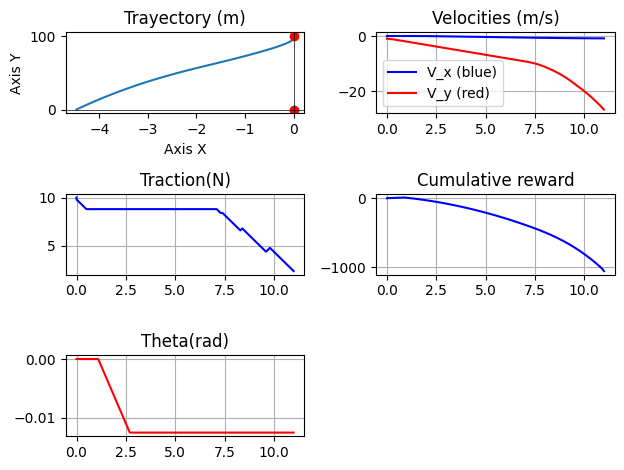

In [61]:
# FINAL SIMULATION, AFTER NN TRAINING

epsilon = 0
cur_frame = 0
time = 0

state = initial_state.astype(np.float32)
matrix_info = np.concatenate((state, [time], [0]))
ep_reward, done = 0, False

while not done:

  if cur_frame > 1000:
    break
  state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
  action = select_epsilon_greedy_action(state_in, epsilon)
  next_state, reward, done = environment(state, action)
  if done == True:
    print(done)
  next_state = next_state.astype(np.float32)
  ep_reward += reward
  time = deltaT * cur_frame

  matrix_info = np.vstack([matrix_info, np.concatenate((state, [time], [ep_reward]))])

  state = next_state
  cur_frame += 1

print('Initial state: ', initial_state)
print('Episode terminated at frame: ', cur_frame, ', time = ', deltaT * cur_frame, 's')
print('Reward reached: ', ep_reward)
plot_traj(matrix_info)